<a href="https://colab.research.google.com/github/Ashutosh-C605/C_codes-templates/blob/main/Explo-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
uploaded = files.upload()

Saving output_final.csv to output_final.csv


In [65]:
import pandas as pd
import numpy as np

df = pd.read_csv("output_final.csv")  # or use: list(uploaded.keys())[0]
features = ['fs', 'L', 'C']
outputs = ['eff', 'vripple', 'iripple']

# Train/test split
train_df = df.iloc[:2000]
test_df = df.iloc[2000:]

X_train = train_df[features]
y_train = train_df[outputs]
X_test = test_df[features]
y_test = test_df[outputs]


In [66]:
from sklearn.preprocessing import StandardScaler

# Scale inputs
input_scaler = StandardScaler()
X_train_scaled = input_scaler.fit_transform(X_train)
X_test_scaled = input_scaler.transform(X_test)

# Scale outputs
output_scaler = StandardScaler()
y_train_scaled = output_scaler.fit_transform(y_train)


In [83]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Build the model
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64,  activation='relu'),
    Dense(3)
])

# Compile
model.compile(optimizer=Adam(learning_rate=0.005), loss='mse', metrics=['mae'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-5)

# Train
history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=300,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Epoch 1/300


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.6937 - mae: 0.5448 - val_loss: 0.6400 - val_mae: 0.4535 - learning_rate: 0.0050
Epoch 2/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3962 - mae: 0.3774 - val_loss: 0.3605 - val_mae: 0.3540 - learning_rate: 0.0050
Epoch 3/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3015 - mae: 0.3082 - val_loss: 0.3018 - val_mae: 0.2993 - learning_rate: 0.0050
Epoch 4/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2602 - mae: 0.2773 - val_loss: 0.4316 - val_mae: 0.3946 - learning_rate: 0.0050
Epoch 5/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2317 - mae: 0.2758 - val_loss: 0.2694 - val_mae: 0.2782 - learning_rate: 0.0050
Epoch 6/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2514 - mae: 0.2567 - val_loss: 0.3070 - val_mae: 0.3176 - learning_rate: 0.0050
Epoch 7/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2275 - mae: 0.2624 - val_loss: 0.2547 - val_mae: 0.2433 - learning_rate: 0.0050
Epoch 8/300
57/57 ━━━━━━━

In [84]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Predict on test data
y_pred_scaled = model.predict(X_test_scaled)
y_pred = output_scaler.inverse_transform(y_pred_scaled)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Test Mean Squared Error:", mse)
print("Test R² Score:", r2)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Test Mean Squared Error: 0.02210039459168911
Test R² Score: 0.9651151299476624


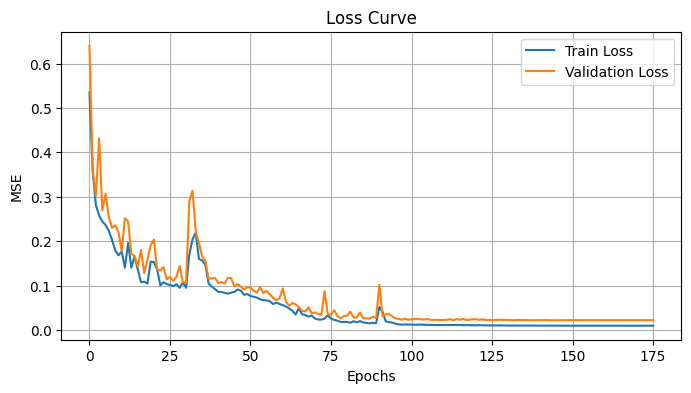

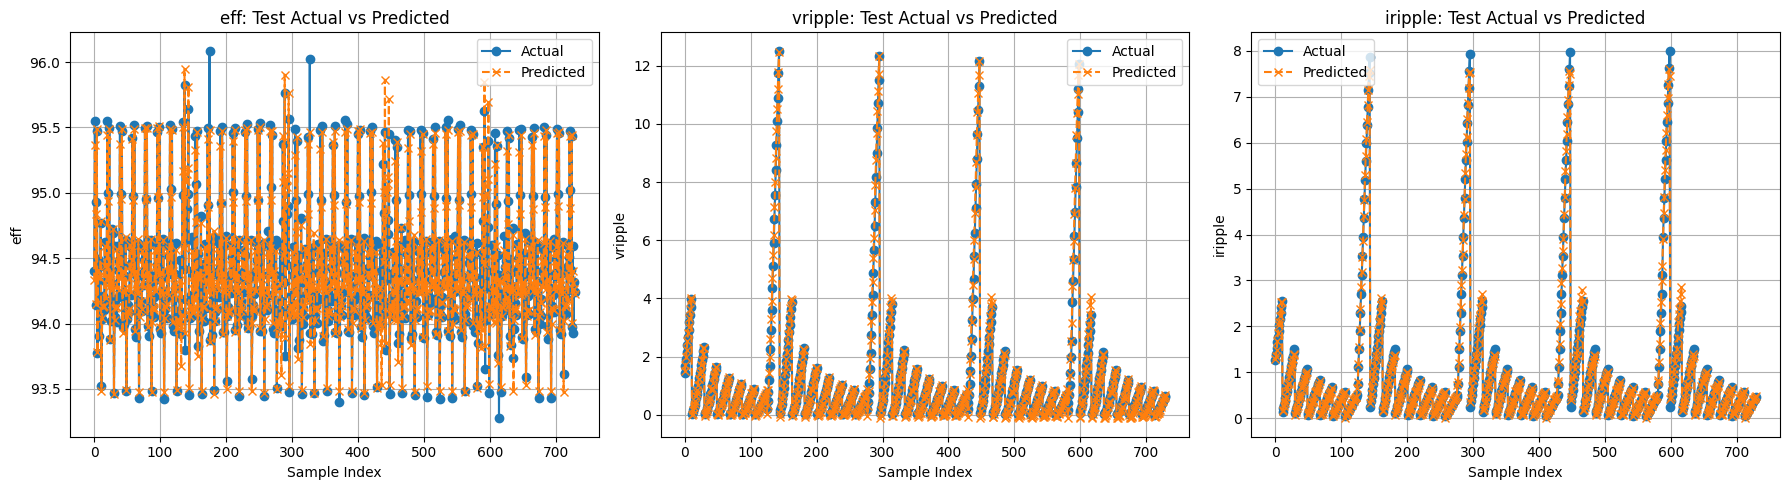

In [85]:
# Loss Curve
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.grid(True)
plt.legend()
plt.show()

# Test Set - Actual vs Predicted
outputs = ['eff', 'vripple', 'iripple']
plt.figure(figsize=(18, 5))
for i, output in enumerate(outputs):
    plt.subplot(1, 3, i+1)
    plt.plot(y_test[output].values, label='Actual', linestyle='-', marker='o')
    plt.plot(y_pred[:, i], label='Predicted', linestyle='--', marker='x')
    plt.title(f'{output}: Test Actual vs Predicted')
    plt.xlabel('Sample Index')
    plt.ylabel(output)
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()


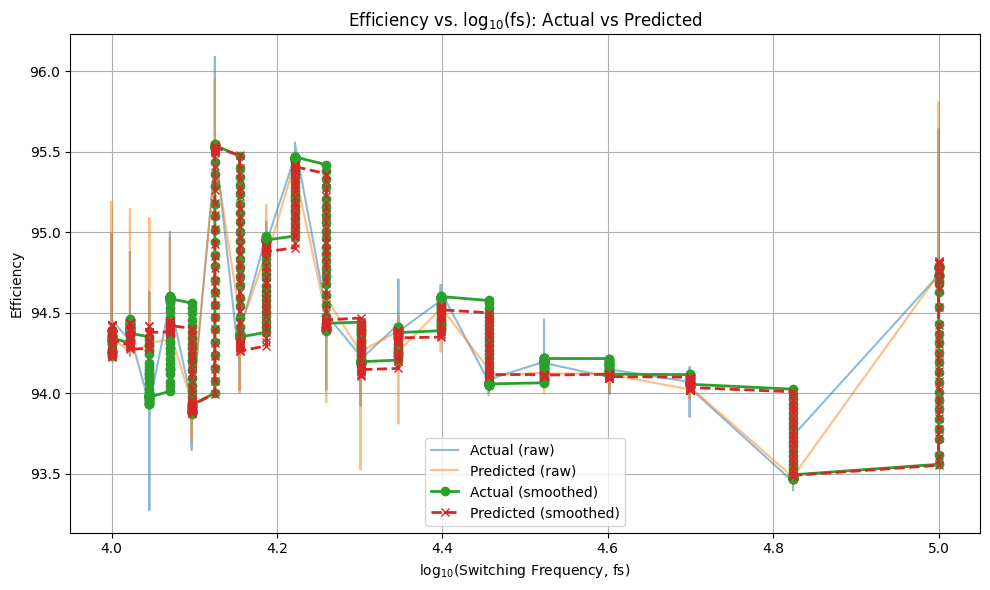

In [86]:
import matplotlib.pyplot as plt

# Index of 'eff' in outputs
eff_index = outputs.index('eff')

# Build results DataFrame
log_fs = np.log10(X_test['fs'].values)
results = pd.DataFrame({
    'log_fs':          log_fs,
    'eff_actual_raw':  y_test['eff'].values,
    'eff_pred_raw':    y_pred[:, eff_index]
})

# Sort by log_fs
results = results.sort_values('log_fs').reset_index(drop=True)

# Apply rolling mean to smooth (window size = 20 samples)
results['eff_actual_smooth'] = results['eff_actual_raw'].rolling(window=20, min_periods=1).mean()
results['eff_pred_smooth']   = results['eff_pred_raw'].rolling(window=20, min_periods=1).mean()

# Plot
plt.figure(figsize=(10, 6))

# raw curves (light)
plt.plot(results['log_fs'], results['eff_actual_raw'],  '-', alpha=0.5, label='Actual (raw)')
plt.plot(results['log_fs'], results['eff_pred_raw'],    '-', alpha=0.5, label='Predicted (raw)')

# smoothed curves (bold)
plt.plot(results['log_fs'], results['eff_actual_smooth'], 'o-', linewidth=2, label='Actual (smoothed)')
plt.plot(results['log_fs'], results['eff_pred_smooth'],   'x--', linewidth=2, label='Predicted (smoothed)')

plt.xlabel(r"log$_{10}$(Switching Frequency, fs)")
plt.ylabel("Efficiency")
plt.title("Efficiency vs. log$_{10}$(fs): Actual vs Predicted")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

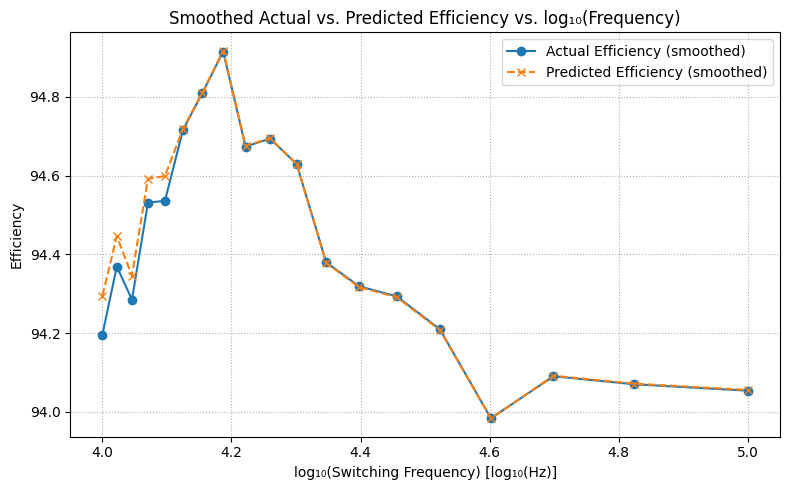

In [87]:

# 1) Build a DataFrame of frequency (raw and log), actual & predicted efficiency
df_plot = pd.DataFrame({
    'fs':        test_df['fs'],                   # raw switching frequency (Hz)
    'fs_log':    np.log10(test_df['fs']),         # log₁₀ of frequency
    'eff_true':  y_test['eff'].values,            # actual efficiency
    'eff_pred':  y_pred[:, 0]                     # predicted efficiency
})

# 2) For each unique log‑frequency, pick the one point with smallest absolute error
df_plot['err'] = np.abs(df_plot.eff_true - df_plot.eff_pred)
best_idxs = df_plot.groupby('fs_log')['err'].idxmin()
df_unique = df_plot.loc[best_idxs].sort_values('fs_log').reset_index(drop=True)

# 3) Smooth both curves with a centered rolling window of size 5
window = 5
df_unique['eff_true_sm'] = df_unique['eff_true'].rolling(window, center=True, min_periods=1).mean()
df_unique['eff_pred_sm'] = df_unique['eff_pred'].rolling(window, center=True, min_periods=1).mean()

# 4) Plot against log10(fs) directly
plt.figure(figsize=(8, 5))

plt.plot(df_unique['fs_log'], df_unique['eff_true_sm'],
         label='Actual Efficiency (smoothed)', marker='o', linestyle='-')
plt.plot(df_unique['fs_log'], df_unique['eff_pred_sm'],
         label='Predicted Efficiency (smoothed)', marker='x', linestyle='--')

plt.xlabel('log₁₀(Switching Frequency) [log₁₀(Hz)]')
plt.ylabel('Efficiency')
plt.title('Smoothed Actual vs. Predicted Efficiency vs. log₁₀(Frequency)')
plt.grid(True, which='both', linestyle=':')
plt.legend()
plt.tight_layout()
plt.show()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


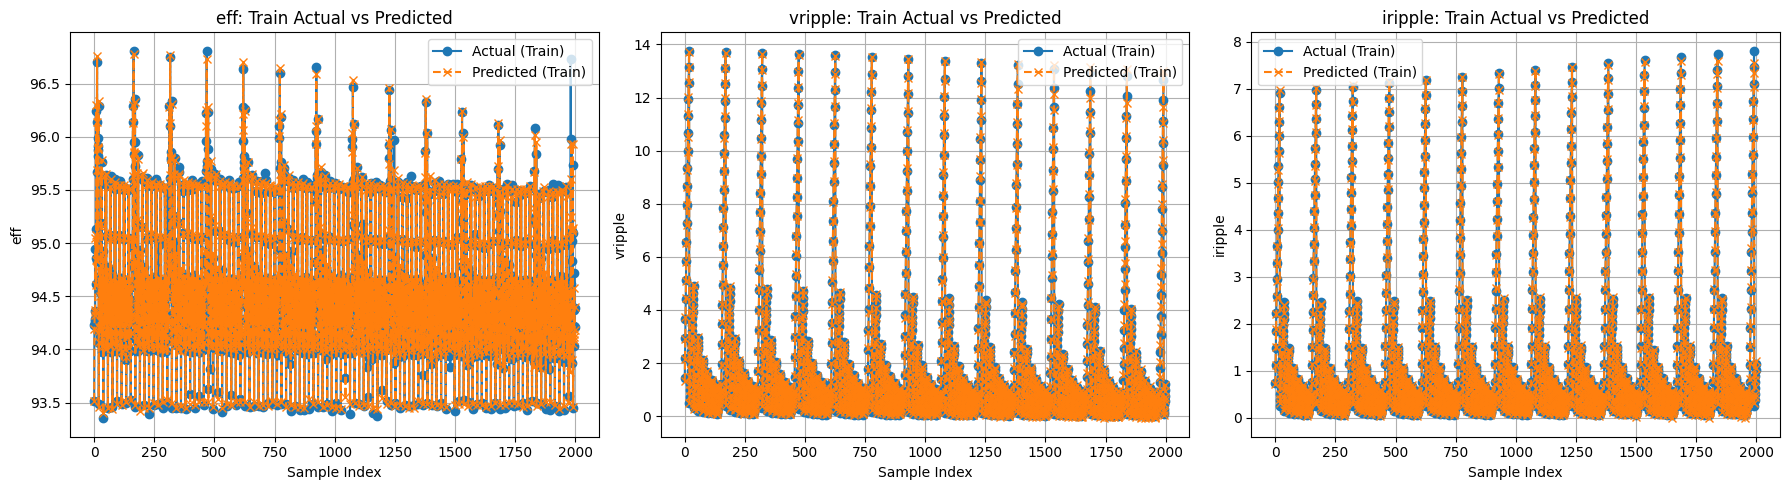

In [71]:
# Train Predictions
y_train_pred_scaled = model.predict(X_train_scaled)
y_train_pred = output_scaler.inverse_transform(y_train_pred_scaled)

plt.figure(figsize=(18, 5))
for i, output in enumerate(outputs):
    plt.subplot(1, 3, i+1)
    plt.plot(y_train[output].values, label='Actual (Train)', linestyle='-', marker='o')
    plt.plot(y_train_pred[:, i], label='Predicted (Train)', linestyle='--', marker='x')
    plt.title(f'{output}: Train Actual vs Predicted')
    plt.xlabel('Sample Index')
    plt.ylabel(output)
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()


In [74]:
!pip install pyswarm

from pyswarm import pso

BOUNDS = {
    'fs': (1e4, 1e5),
    'L': (1e-6, 1.5e-3),
    'C': (5e-8, 5e-6)
}

MAX_VRIPPLE = 5.0
MAX_IRIPPLE = 1.0

def objective(x):
    fs, L, C = x
    X_input = pd.DataFrame([[fs, L, C]], columns=['fs', 'L', 'C'])
    X_scaled = input_scaler.transform(X_input)
    pred_scaled = model.predict(X_scaled)
    eff, vripple, iripple = output_scaler.inverse_transform(pred_scaled)[0]

    penalty = 0
    if vripple > MAX_VRIPPLE:
        penalty += (vripple - MAX_VRIPPLE) ** 2
    if iripple > MAX_IRIPPLE:
        penalty += (iripple - MAX_IRIPPLE) ** 2

    return -eff + penalty + 0.1 * (vripple + iripple)

lb = [BOUNDS['fs'][0], BOUNDS['L'][0], BOUNDS['C'][0]]
ub = [BOUNDS['fs'][1], BOUNDS['L'][1], BOUNDS['C'][1]]

best_input, best_score = pso(objective, lb, ub, swarmsize=20, maxiter=30, debug=True)


No constraints given.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [75]:
X_input = np.array([best_input])
X_scaled = input_scaler.transform(X_input)
y_pred_scaled = model.predict(X_scaled)
eff, vripple, iripple = output_scaler.inverse_transform(y_pred_scaled)[0]

print("\n🎯 Best Input Found:")
print(f"fs = {best_input[0]:.2f}")
print(f"L  = {best_input[1]:.6e}")
print(f"C  = {best_input[2]:.6e}")

print("\n📈 Predicted Outputs:")
print(f"eff      = {eff:.4f}")
print(f"vripple  = {vripple:.4f}")
print(f"iripple  = {iripple:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step

🎯 Best Input Found:
fs = 17380.64
L  = 1.465361e-03
C  = 2.758547e-06

📈 Predicted Outputs:
eff      = 95.6449
vripple  = 0.4871
iripple  = 0.2753


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
